In [37]:
import qcomplexity as qc
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import minimize
import numpy as np
from scipy.optimize import fsolve
from tqdm.notebook import tqdm

np.set_printoptions(linewidth=100000)

# Geodesic

The following code will generate a plot showing the path taken from initial to final parameters on the unitary manifold.

In [19]:
# Hardness of different unitary generators
inertia = jnp.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.1]
])

metric = jax.jit(qc.numerical_metric(inertia, qc.ham_fn)) # Metric tensor
christoffel_symbols = jax.jit(qc.numerical_christoffel_symbols(metric)) # Christoffel symbols

In [20]:
# The right-hand side of the geodesic differential equation
diff_fn = lambda *args : jnp.real(qc.diff_fn(christoffel_symbols)(*args))
jit_diff = jax.jit(diff_fn)

In [25]:
# Initial conditions
init = jnp.array([0.0, 0.0, 0.0], dtype=complex)

In [22]:
# Creates the path ODE solver
nodes = 50
path_solver = qc.solve_geodesic_path(jit_diff, nodes)

In [26]:
# We will look at the geodesic beginning at init, with tangent vector given by:
v = jnp.array([0.5, 0.5, 0.5], dtype=complex)

In [27]:
# We run the ODE solver
x, v = path_solver(v)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


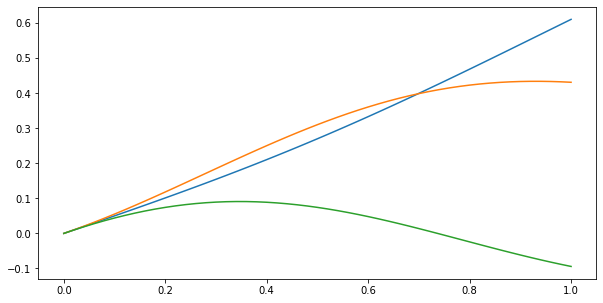

In [36]:
# We can then plot the paths taken by each unitary parameter
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, nodes+1), x)

# Complexity of the Time-Evolution Operator

The following snippets of code will generate a plot showing the complexity of the time-evolution operator over time. We recycle some the code from above (the metric, the Christoffel symbols, etc.)

In [24]:
# Boundary conditions
fin = jnp.array([0.0, 0.3816, 0.4387], dtype=complex)

In [23]:
# Creates the endpoint ODE solver
endpoint_solver = qc.solve_geodesic_ivp(jit_diff, nodes)

In [14]:
def complexity(fin, v_guess):
    cost = lambda v : np.real(endpoint_solver(v) - fin)
    solve_val = fsolve(cost, v_guess, full_output=True)
    good_v = solve_val[0]
    
    x, v = path_solver(good_v)
    # Returns the geodesic length and the error vector
    return qc.length(metric, x, v, 1/nodes), solve_val[1]['fvec']

In [16]:
v_guess = jnp.array([0.0, 1.0, 1.0])
C_vals = []

for t in np.linspace(0, 5.4, 100):
    out, error = complexity(t * fin, v_guess)
    C_vals.append(out)
    print("Error = {}".format(np.linalg.norm(error)))

Error = 0.0
Error = 7.730402404518616e-09
Error = 1.5359765983484536e-08
Error = 1.862645764044155e-08
Error = 3.071953105046809e-08
Error = 1.0536758656845494e-08
Error = 3.071953412681932e-08
Error = 2.9802323934026425e-08
Error = 6.143941132722028e-08
Error = 1.4901276136707065e-08
Error = 2.107342900886498e-08
Error = 6.3008036288447755e-12
Error = 6.143909551621095e-08
Error = 1.4902193076386472e-07
Error = 5.96051083729618e-08
Error = 2.985134596371115e-08
Error = 1.519626659864005e-07
Error = 6.665607138221554e-08
Error = 4.221006362747506e-08
Error = 2.9805452584497255e-08
Error = 4.2340857465435326e-08
Error = 2.747657511691477e-07
Error = 2.9802383795846995e-08
Error = 2.3287819622894146e-07
Error = 1.2290031399375482e-07
Error = 1.8963871368809276e-07
Error = 1.7894511112738073e-07
Error = 5.962215881348494e-08
Error = 1.1927561117560765e-07
Error = 6.14956540981873e-08
Error = 8.437712443178279e-08
Error = 1.7881680155116442e-07
Error = 3.576316921485347e-07
Error = 5.96176

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


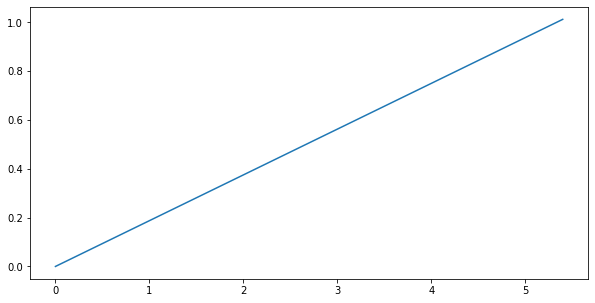

In [38]:
# Plots the complexity over time
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 5.4, 100), C_vals)